## Data Visualization
This week we will be building off what we learned last week about working with tabular data in Python and expanding it to explore that data visually using matplotlib and altair.

## Data Structures
pandas introduces two new data structures to Python - Series and DataFrame, both of which are built on top of NumPy (this means it's fast).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
%matplotlib inline

Our file had headers, which the function inferred upon reading in the file. Had we wanted to be more explicit, we could have passed header=None to the function along with a list of column names to use:

## Working with DataFrames
We'll be using the MovieLens dataset from Lab 5

In [3]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('users.csv', names=u_cols,)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ratings.csv', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('movies.csv', names=m_cols, usecols=range(5))
# movies['movie_id'] = pd.to_numeric(movies['movie_id'], errors='coerce').fillna(1)
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [4]:
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


# matplotlib
Let's use matplotlib look at how these movies are viewed across different age groups. First, let's look at how age is distributed amongst our users.

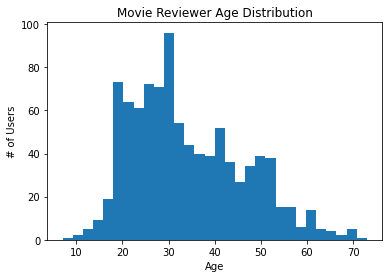

In [5]:
# Create a histogram with 30 bins
plt.hist(users['age'], bins=30)
# Set title
plt.title('Movie Reviewer Age Distribution')
# Set axis labels
plt.xlabel('Age')
plt.ylabel('# of Users')
plt.show()

pandas' integration with matplotlib makes basic graphing of Series/DataFrames trivial. In this case, just call hist on the column to produce a histogram. We can also use matplotlib.pyplot to customize our graph a bit (always label your axes).

## Effective data visualization
Think of some questions that would give me more insight into the data at hand, then identify the best method to visualise the answer to our question — the best method may be defined as the most simple and clear way to express the answer to our question.

### What are the top 10 most rated movies?

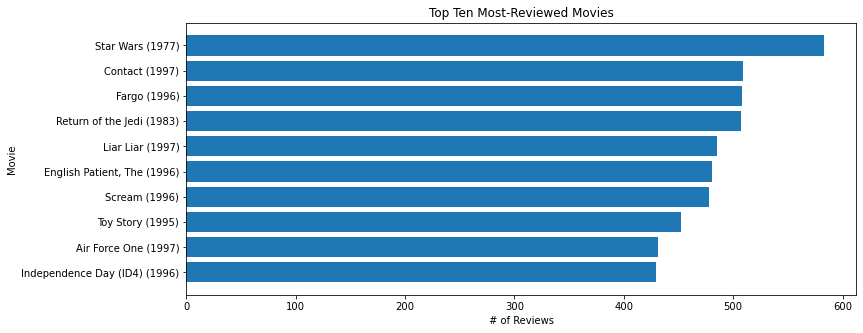

In [6]:
# return number of rows associated to each title
top_ten_movies = lens.groupby("title").size().sort_values(ascending=False)[:10].sort_values(ascending=True)
# plot the counts
plt.figure(figsize=(12, 5))
# Create a horizontal bar chart based on the index & values
plt.barh(y=top_ten_movies.index, width=top_ten_movies.values)
    
# Set title and axis labels and show
plt.title('Top Ten Most-Reviewed Movies')
plt.ylabel('Movie')
plt.xlabel('# of Reviews')

plt.show()

## How many movies were released per year?
Let's use a line chart to investigate.

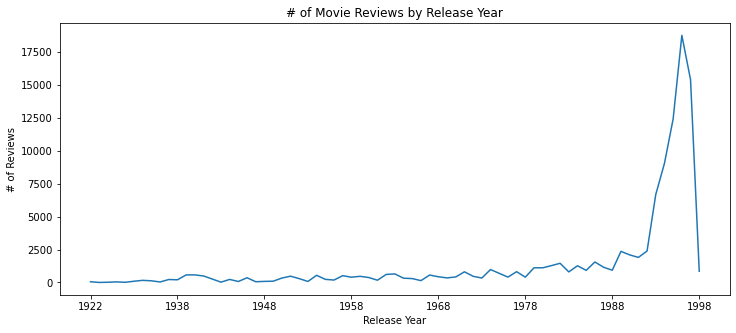

In [7]:
# create the year column from Movie title 
lens["year"] = lens["title"].str.extract("\((\d{4})\)", expand=True)

# return number of rows by the year 
year_counts = lens[["title", "year"]].groupby("year").size()

# Create a 12x5 plot and use subplots to get access to axis parameters (ax)
fig, ax = plt.subplots(figsize=(12, 5)) 
# Use the axes objects to plot indices & values
ax.plot(year_counts.index, year_counts.values)
# Change x-axis parameters to display a maximum of 9 ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(9)) 
# Set title, axis labels and show
plt.title('# of Movie Reviews by Release Year')
plt.xlabel('Release Year')
plt.ylabel('# of Reviews')
    
plt.show()

## How many Men/Women rated movies?
Let's try changing the colors

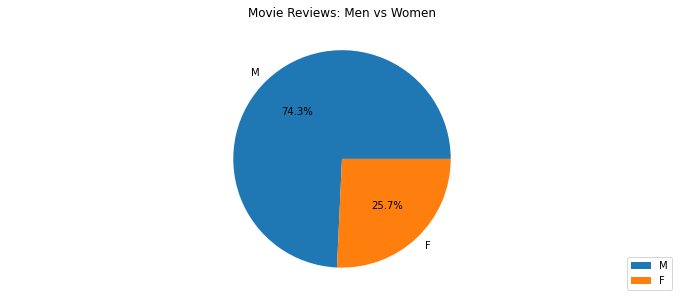

In [8]:
# count the number of male and female raters
gender_counts = lens.gender.value_counts()
# plot the counts 
plt.figure(figsize=(12, 5))
# Set up equal axis for pie charts
plt.axis('equal')
# Create a pie plot using values, index as labels, and display labels to one decimal point
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
# Add a legend to the lower right
plt.legend(loc='lower right')
# Add title and show
plt.title('Movie Reviews: Men vs Women')
plt.show()


### Which movies do men and women most disagree on?

Text(0.5, 0, 'Average Rating Difference (Men-Women)')

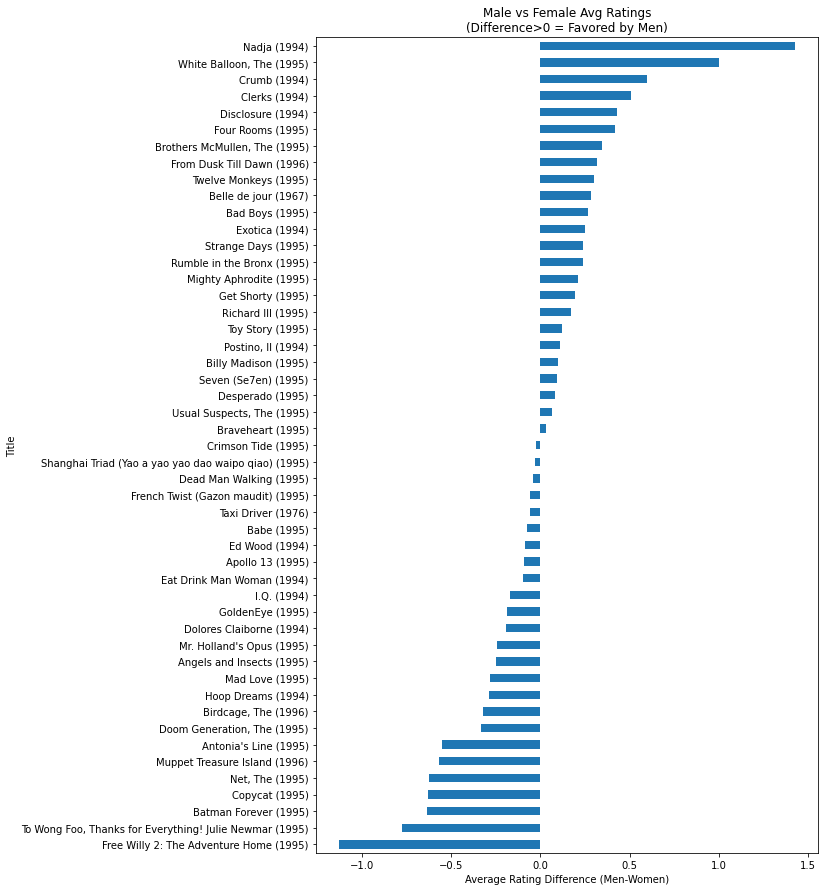

In [9]:
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)
# Calc diff between men and women
pivoted['diff'] = pivoted.M - pivoted.F
# Reset the dataframe index to be the movie_id field (for groupby calculations)
pivoted.reset_index('movie_id', inplace=True)
# Get top 50 most rated movies (similar to top 10 above)
most_rated = lens.groupby(['title', 'movie_id']).size().sort_values(ascending=False).reset_index()[:50]
# Only look at disagreement diffs for top 50 movies, and only save the diff field
disagreements = pivoted[pivoted.movie_id.isin(most_rated.index)]['diff']
# Sort these disagreements and plot them as a horizontal bar plot (9x15)']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])

# Add title and axis labels
plt.title('Male vs Female Avg Ratings\n(Difference>0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference (Men-Women)')

### Visualization with Altair
Altair is a declarative statistical visualization library for Python, based on Vega and Vega-Lite. Altair offers a powerful and concise visualization grammar that enables you to build a wide range of statistical visualizations quickly.  

The key idea for this library is that you are declaring links between data columns and visual encoding channels, such as the x-axis, y-axis, color, etc. The rest of the plot details are handled automatically. Building on this declarative plotting idea, a surprising range of simple to sophisticated plots and visualizations can be created using a relatively concise grammar.

#### Installing altair
Before we can start using altair, we need to install it, as it does not come installed by default with Anaconda. Luckily Jupyter provides a handy magic command for installing new packages directly from within a notebook.

*Note: you only need to do this once. Once it is installed you don't need to run this command again*

In [10]:
# Install a conda package in the current Jupyter kernel
import sys
# After you run this, you can comment out this line so you don't try to run it again
!conda install --yes --prefix {sys.prefix} -c conda-forge altair vega_datasets

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done


The data used internally by Altair is stored in Pandas DataFrame format, but there are four ways to pass it in:  
* as a Pandas DataFrame
* as a Data or related object
* as a url string pointing to a json or csv formated file  

Here is an example of importing Altair, and creating a simple DataFrame to visualize, with a categorical variable in column col-1 and a numerical variable in column col-2:

In [11]:
import altair as alt
data = pd.DataFrame({'col-1': list('CCCDDDEEE'),
                     'col-2': [2, 7, 4, 1, 2, 6, 8, 4, 7]})
chart = alt.Chart(data)

After selecting data, you need to choose various charts such as bar charts, line charts, area charts, scatter charts, histograms, and maps. The mark property is what specifies how exactly those attribute should be represent on the plot. Altair provide a number of basic mark properties:
<img src='https://miro.medium.com/max/875/1*QRDSkZXspfnPJtBiq5uLxA.png'>

In [12]:
# Use the mark_point() method to display data
chart = alt.Chart(data).mark_point()
chart

alt.Chart(...)

The reason we got a single point display is that the rendering consists of one point per row in the dataset, all plotted on top of each other, since we have not yet specified positions for these points. And that will be resolved with **Encodings**.

In Altair, encodings is the mapping of data to visual properties such as axis, color of marker, shape of marker etc. The encoding method Chart.encode() defines various properties of chart display and it is the most important function to create meaningful visualization. The official user guide provides a long list of supported properties. The following are the most basic encoding properties and knowing them should be enough for you to create basic charts.  

Position channels  
* x: the x-axis value
* y: the y-axis value
* row: The row of a faceted plot
* column: the column of a faceted plot  

Mark Property channels  
* color: the color of the mark
* opacity: the opacity of the mark
* shape: the shape of mark
* size: the size of mark  

Text channel  
* text: text to use for mark  

Data Types  
* quantitative: shorthand code Q, a continuous real-valued quantity
* ordinal: shorthand code O, a discrete ordered quantity
* nominal: shorthand code N, a discrete ordered quantity
* temporal: shorthand code T, a time or date value

In [13]:
# Add in encodings for x & y
alt.Chart(data).mark_point().encode(x='col-1', y='col-2')
    
    
    

alt.Chart(...)

#### Making Charts Interactive
In addition to basic charts, one of the unique features of Altair is that users can interact with charts, including controls such as panning, zooming, and selecting a range of data.  
Behind the theme, you can implement the pan and zoom by just calling the interactive() module. For example:

In [15]:
# Now make it interactive!
alt.Chart(data).mark_point().encode(x='col-1', y='col-2').interactive()

    
    

alt.Chart(...)

#### Making an Interactive Chart using Real World Data
Lets try to make an interactive chart using some of the sample data provided in the vega_datasets package. The cars dataset provides a lot of info about makes and models of cars, such as horsepower, weight, etc.

In [16]:
from vega_datasets import data
cars = data.cars()
cars.head()

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA


First we’ll create an interval selection using the selection_interval() function:

In [17]:
# Create a brush variable that listens for selections on altair plots
brush = alt.selection_interval()

We can now bind this brush to our chart by setting the selection property:

In [18]:
# Create an altair scatter plot comparing Miles_per_Gallon (x) vs Horsepower (y) and color by Origin
# Also add the interactive selection brush created above
alt.Chart(cars).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color='Origin:N'
).add_selection(brush)

alt.Chart(...)

The result above is a chart that allows you to click and drag to create a selection region, and to move this region once the region is created. This is neat, but the selection doesn’t actually do anything yet.  

To use this selection, we need to reference it in some way within the chart. Here, we will use the condition() function to create a conditional color encoding: we’ll tie the color to the "Origin" column for points in the selection, and set the color to "lightgray" for points outside the selection:

In [19]:
# Same as above, but change the color to be grey for those points not in the brush selection
alt.Chart(cars).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(brush)

alt.Chart(...)

Next, we create a mark_bar() chart

In [20]:
# Use altair to make a bar chart with the Origin country along the y-axis and counts on the x-axis. Color by Origin
alt.Chart(cars).mark_bar().encode(
    y='Origin:N',
    color='Origin:N',
    x='count(Origin):Q'
)

alt.Chart(...)

In order to associate bar chart with the previous scatter chart, we need to use transform_filter() and pass the same brush. In addition, for composing multiple selection chart, we also need to create variable for each of them and use Composing Multiple selections & .

In [21]:
# points plot exactly the same as above
points = alt.Chart(cars).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(brush)

# On the bar chart, add a transform_filter to listen to the brush
bars = alt.Chart(cars).mark_bar().encode(
    y='Origin:N',
    color='Origin:N',
    x='count(Origin):Q'
).transform_filter(brush)

# Display points and bars
points & bars

alt.VConcatChart(...)

# Homework
## Undergrads & Grads

Using the COVID-19 data from Lab 5, make a new DataFrame of the countries with the top 25 confirmed cases on the latest date (9/27/2021), and create a matplotlib bar chart plotting these top 25 countries vs confirmed cases on this date (Hint: Y-axis is Country/Region and X-axis is Confirmed)

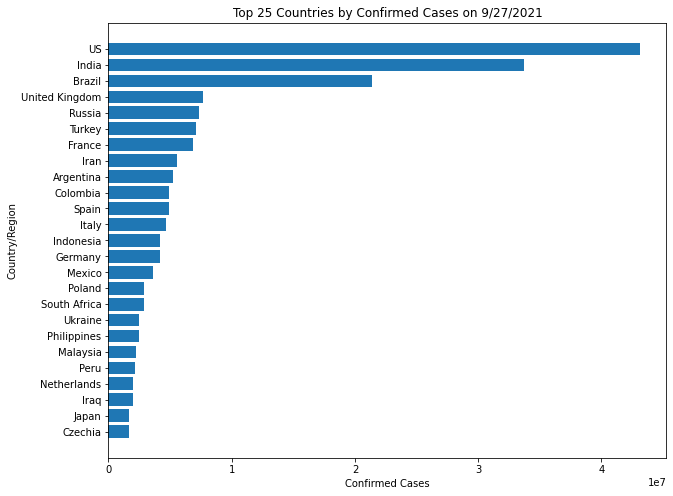

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

confirmed_df = pd.read_csv('time_series_covid19_confirmed_global_long.csv')
# Convert the 'Date' column to datetime data type
confirmed_df['Date'] = pd.to_datetime(confirmed_df['Date'])
latest = confirmed_df[confirmed_df['Date']=='9/27/21']
latest
# Sort the DataFrame by confirmed cases to get the top 25 countries
top_25_countries = latest.sort_values(by='Confirmed', ascending=False).head(25)
top_25_countries

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_25_countries['Country/Region'], top_25_countries['Confirmed'])
plt.xlabel('Confirmed Cases')
plt.ylabel('Country/Region')
plt.title('Top 25 Countries by Confirmed Cases on 9/27/2021')
plt.gca().invert_yaxis()  # Invert the Y-axis to show the highest number of cases at the top
plt.show()

Make a line chart of **US** confirmed case count over time

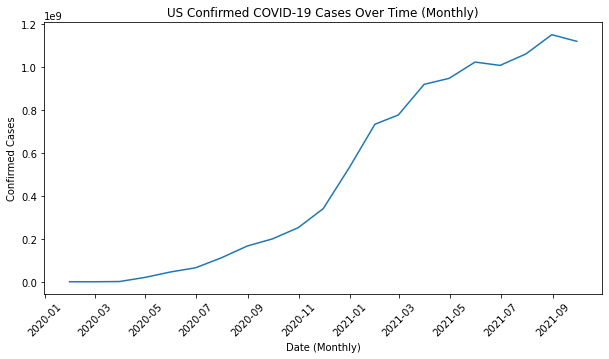

In [18]:
# Filter data for the United States (Country/Region == 'US')
us_data = confirmed_df[confirmed_df['Country/Region'] == 'US'].copy()  # Create a copy to avoid the SettingWithCopyWarning

# Convert the 'Date' column to datetime data type
us_data['Date'] = pd.to_datetime(us_data['Date'])

# Group data by month and sum the confirmed cases so it will look briefly
us_confirmed_by_month = us_data.resample('M', on='Date')['Confirmed'].sum()

# Create a line chart
plt.figure(figsize=(10, 5))
plt.plot(us_confirmed_by_month.index, us_confirmed_by_month.values)
plt.title('US Confirmed COVID-19 Cases Over Time (Monthly)')
plt.xlabel('Date (Monthly)')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


Load the Seattle weather dataset from the Vega sample datasets (seattle_weather). This dataset gives daily precipitation, min/max temperature, wind velocity and weather description for 2012-2015.

In [29]:
from vega_datasets import data

# Load the Seattle weather dataset
seattle_weather = data.seattle_weather()

# Display the first few rows of the dataset
print(seattle_weather.head(15))


         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain
5  2012-01-06            2.5       4.4       2.2   2.2     rain
6  2012-01-07            0.0       7.2       2.8   2.3     rain
7  2012-01-08            0.0      10.0       2.8   2.0      sun
8  2012-01-09            4.3       9.4       5.0   3.4     rain
9  2012-01-10            1.0       6.1       0.6   3.4     rain
10 2012-01-11            0.0       6.1      -1.1   5.1      sun
11 2012-01-12            0.0       6.1      -1.7   1.9      sun
12 2012-01-13            0.0       5.0      -2.8   1.3      sun
13 2012-01-14            4.1       4.4       0.6   5.3     snow
14 2012-01-15            5.3       1.1  

Create a pie chart using matplotlib, showing the percentage of days by weather type (sun, rain, snow, etc.)

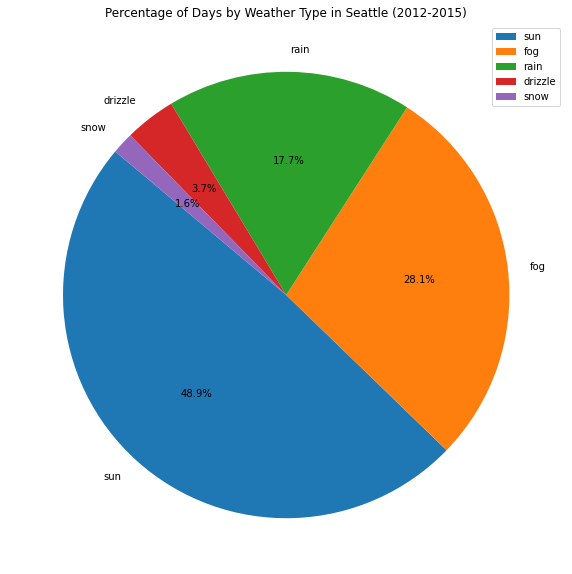

In [22]:
# Calculate the percentage of days by weather type
weather_counts = seattle_weather['weather'].value_counts()
total_days = len(seattle_weather)
weather_percentage = (weather_counts / total_days) * 100

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.pie(weather_percentage, labels=weather_percentage.index, autopct='%1.1f%%', startangle=140)

# Add a legend to the upper right
plt.legend(loc='upper right')

plt.title('Percentage of Days by Weather Type in Seattle (2012-2015)')
plt.show()

Create a histogram of Seattle wind velocities using orange color bars and 25 bins.

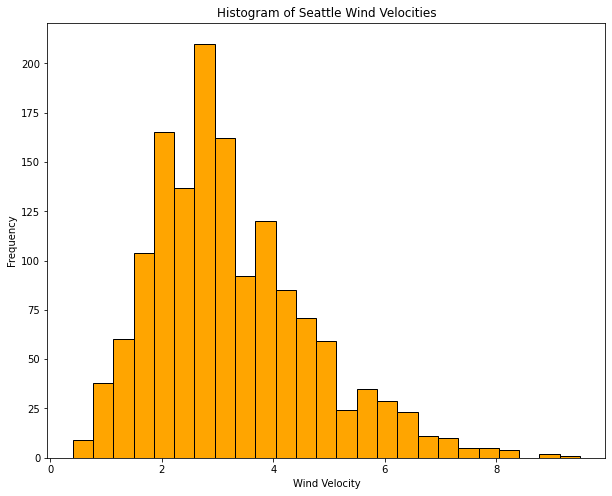

In [28]:
# Extract the wind velocities from the Seattle weather dataset
wind_velocities = seattle_weather['wind']

# Create a histogram
plt.figure(figsize=(10, 8))
plt.hist(wind_velocities, bins=25, color='orange', edgecolor='black')
plt.xlabel('Wind Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Seattle Wind Velocities')
plt.show()

## Just Grads

Using altair and the Seattle weather data, make an interactive chart of daily minimum temperatures for the month of January 2012. When the user selects on the chart, make it show the average minimum temperature as a horizontal red reference line **just for the selected dates**. *(Hint: check out this example: https://altair-viz.github.io/gallery/selection_layer_bar_month.html)*

In [33]:
import altair as alt
from vega_datasets import data

seattle_weather = data.seattle_weather()

# Filter data for January 2012
january_2012_data = seattle_weather[(seattle_weather['date'] >= '2012-01-01') & (seattle_weather['date'] <= '2012-01-31')]

# print(january_2012_data.columns)
# Create the base chart
base = alt.Chart(january_2012_data).mark_bar().encode(
    x='date:T',
    y='temp_min:Q',  # Use 'temp_min' for minimum temperatures
    color=alt.condition(
        alt.selection_interval(name="my_selection"),  # Define a unique selection name
        alt.value('steelblue'),  # Color for selected data
        alt.value('lightgray')  # Color for unselected data
    )
).properties(
    width=800,
    height=300
)

# Calculate the average minimum temperature
average_min_temp = january_2012_data['temp_min'].mean()

# Create a red reference line for the average minimum temperature
reference_line = alt.Chart(pd.DataFrame({'average_min_temp': [average_min_temp]})).mark_rule(color='red').encode(
    y='average_min_temp:Q'
)

# Add a selection
selection = alt.selection_interval(name="my_selection", encodings=['x'])  # Use the same unique selection name

# Combine the base chart, the reference line, and the selection
chart = alt.layer(base, reference_line).add_selection(selection)

chart

alt.LayerChart(...)

Using the COVID-19 data from Lab 5 and altair, create a bar chart showing the countries (including states/provinces is fine) with the top 25 most confirmed cases on the most recent date. Also create a line chart showing total deaths over time, and make it interactive so if the user selects a country in the bar chart, it updates the line chart to only show the deaths over time for that country.

In [56]:
import pandas as pd
import altair as alt

# Read the COVID-19 data
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global_long.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global_long.csv')

# Choose the most recent date
latest_date = confirmed_df['Date'].max()

# Filter data for the most recent date
latest_data = confirmed_df[confirmed_df['Date'] == latest_date]

# Sort data by confirmed cases to get the top 25 countries
top_25_countries = latest_data.sort_values(by='Confirmed', ascending=False).head(25)

# Create a bar chart for the top 25 countries
bar_chart = alt.Chart(top_25_countries).mark_bar().encode(
    x=alt.X('Confirmed:Q', title='Confirmed Cases'),
    y=alt.Y('Country/Region:N', title='Country/Region', sort='-x')
).properties(
    width=400
)

# Create an altair selection variable for interactive brushing
brush = alt.selection_interval(encodings=['x'], empty='all')

# Create a selection for the bar chart
country_selection = alt.selection_multi(fields=['Country/Region'], bind='legend')

# Group deaths data by month and year, and calculate the total deaths for each group
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'])
deaths_df['MonthYear'] = deaths_df['Date'].dt.strftime('%Y-%m')
monthly_deaths = deaths_df.groupby(['MonthYear', 'Country/Region'])['Deaths'].sum().reset_index()

# Create a line chart for total deaths over time (aggregated by month)
line_chart = alt.Chart(monthly_deaths).mark_line().encode(
    x=alt.X('MonthYear:T', title='Date'),
    y=alt.Y('Deaths:Q', title='Total Deaths'),
    color=alt.Color('Country/Region:N', legend=alt.Legend(title='Country/Region'), scale=alt.Scale(scheme='category20'))
).add_selection(country_selection).properties(
    width=800,
    height=400
)

# Link the brushing selection from the bar chart to the line chart
bar_chart = bar_chart.add_selection(brush)
line_chart = line_chart.transform_filter(brush)

# Combine the bar chart and line chart
chart = (bar_chart | line_chart)

chart


alt.HConcatChart(...)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.HConcatChart(...)

alt.Chart(...)